In [82]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [83]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [84]:
def load_eol_data(file_path):
    """Load and prepare EOL data from JSON file"""
    with open(file_path, 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data)

    # Convert eol_from to datetime
    df['eol_from'] = pd.to_datetime(df['eol_from'], errors='coerce')

    # Calculate days since EOL
    current_date = datetime.now()
    df['days_since_eol'] = (current_date - df['eol_from']).dt.days

    # Create risk severity categories
    def categorize_risk(row):
        if pd.isna(row['is_eol']) or row['is_eol'] is None:
            return 'Unknown'
        elif not row['is_eol']:
            return 'Current'
        elif pd.isna(row['days_since_eol']):
            return 'EOL (Date Unknown)'
        elif row['days_since_eol'] <= 180:  # 6 months
            return 'EOL 0-6 months'
        elif row['days_since_eol'] <= 365:  # 1 year
            return 'EOL 6-12 months'
        elif row['days_since_eol'] <= 730:  # 2 years
            return 'EOL 1-2 years'
        else:
            return 'EOL 2+ years'

    df['risk_category'] = df.apply(categorize_risk, axis=1)

    return df

In [85]:
df = load_eol_data('../OldPort80/server_eol_all_for_transip.json')

print("Data loaded successfully!")
print(f"Total hosts analyzed: {len(df)}")
print("\nData preview:")
print(df[['ip', 'server', 'version', 'is_eol', 'risk_category']])

Data loaded successfully!
Total hosts analyzed: 997

Data preview:
                  ip         server version is_eol risk_category
0     149.210.211.23         Apache     2.0   True  EOL 2+ years
1    136.144.187.150         Apache     2.2   True  EOL 2+ years
2    149.210.130.223         Apache     2.2   True  EOL 2+ years
3    149.210.131.117         Apache     2.2   True  EOL 2+ years
4     149.210.138.38         Apache     2.2   True  EOL 2+ years
..               ...            ...     ...    ...           ...
992    37.97.174.150  Microsoft-IIS     8.5   None       Unknown
993    37.97.192.154  Microsoft-IIS     8.5   None       Unknown
994    37.97.238.144  Microsoft-IIS     8.5   None       Unknown
995    37.97.240.163  Microsoft-IIS     8.5   None       Unknown
996     37.97.253.61  Microsoft-IIS     8.5   None       Unknown

[997 rows x 5 columns]


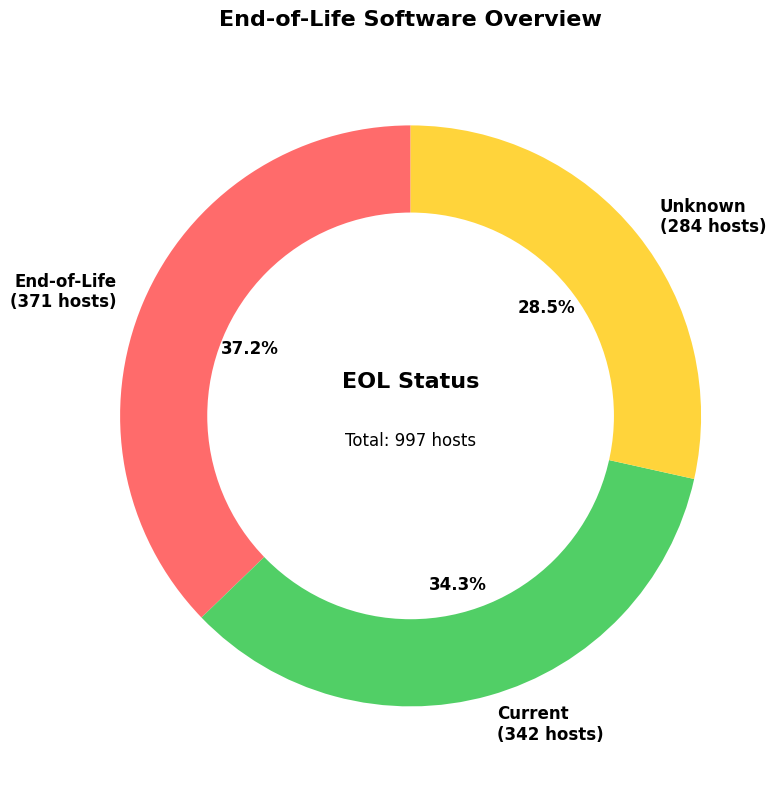

In [90]:
def create_eol_status_overview(df):
    """Create EOL status overview pie chart"""

    # Calculate EOL status counts
    eol_status = df['is_eol'].value_counts()
    unknown_count = df['is_eol'].isna().sum()

    labels = []
    sizes = []
    colors = []

    if True in eol_status.index:
        labels.append(f'End-of-Life\n({eol_status[True]} hosts)')
        sizes.append(eol_status[True])
        colors.append('#ff6b6b')  # Red for EOL

    if False in eol_status.index:
        labels.append(f'Current\n({eol_status[False]} hosts)')
        sizes.append(eol_status[False])
        colors.append('#51cf66')  # Green for current

    if unknown_count > 0:
        labels.append(f'Unknown\n({unknown_count} hosts)')
        sizes.append(unknown_count)
        colors.append('#ffd43b')  # Yellow for unknown

    # Create the pie chart
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create donut chart
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                                      startangle=90, wedgeprops=dict(width=0.5),
                                      textprops={'fontsize': 12, 'weight': 'bold'})

    # Add center circle for donut effect
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)

    # Add title and stats in center
    ax.text(0, 0.1, 'EOL Status', horizontalalignment='center', fontsize=16, weight='bold')
    ax.text(0, -0.1, f'Total: {len(df)} hosts', horizontalalignment='center', fontsize=12)

    plt.title('End-of-Life Software Overview', fontsize=16, weight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('eol_overview_plot_transip.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()



create_eol_status_overview(df)

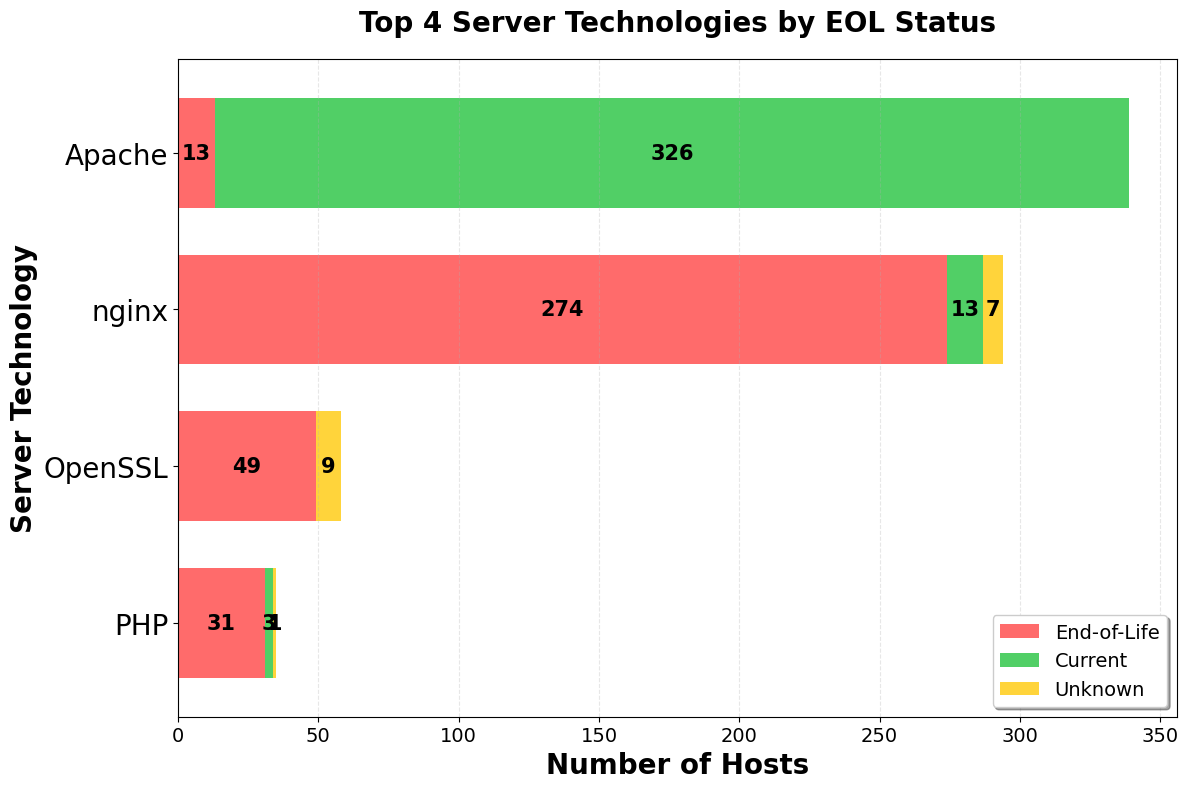


🖥️  Top 4 Server Technology Summary:
   • Apache: 339 hosts (13 EOL)
   • nginx: 294 hosts (274 EOL)
   • OpenSSL: 58 hosts (49 EOL)
   • PHP: 35 hosts (31 EOL)
   • Other technologies (21): 271 hosts


In [87]:
def create_server_technology_distribution(df):
    """Create server technology distribution horizontal bar chart"""

    # Group by server type and EOL status
    server_eol = df.groupby(['server', 'is_eol']).size().unstack(fill_value=0)

    # Add unknown category if it exists
    if df['is_eol'].isna().any():
        unknown_counts = df[df['is_eol'].isna()].groupby('server').size()
        server_eol['Unknown'] = unknown_counts.reindex(server_eol.index, fill_value=0)

    # Calculate total hosts per server and get top 4
    total_by_server = server_eol.sum(axis=1).sort_values(ascending=False)
    top_4_servers = total_by_server.head(4).index

    # Filter to keep only top 4 servers and sort by total (descending)
    server_eol = server_eol.loc[top_4_servers]
    server_eol = server_eol.loc[server_eol.sum(axis=1).sort_values(ascending=True).index]  # Sort ascending for horizontal bar chart

    # Reorder columns for better visualization
    column_order = []
    if True in server_eol.columns:
        column_order.append(True)
    if False in server_eol.columns:
        column_order.append(False)
    if 'Unknown' in server_eol.columns:
        column_order.append('Unknown')

    server_eol = server_eol[column_order]

    # Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(12, 8))

    # Define colors
    colors = {'True': '#ff6b6b', 'False': '#51cf66', 'Unknown': '#ffd43b'}
    color_list = [colors.get(str(col), colors.get(col, '#74c0fc')) for col in server_eol.columns]

    # Create stacked horizontal bar chart
    server_eol.plot(kind='barh', stacked=True, ax=ax, color=color_list, width=0.7)

    # Customize the chart
    ax.set_title('Top 4 Server Technologies by EOL Status', fontsize=20, weight='bold', pad=20)
    ax.set_xlabel('Number of Hosts', fontsize=20, weight='bold')
    ax.set_ylabel('Server Technology', fontsize=20, weight='bold')

    # Set server names (y-axis labels) font size to 20
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=14)

    # Customize legend
    legend_labels = []
    for col in server_eol.columns:
        if col is True:
            legend_labels.append('End-of-Life')
        elif col is False:
            legend_labels.append('Current')
        else:
            legend_labels.append('Unknown')

    ax.legend(legend_labels, loc='lower right', frameon=True, fancybox=True, shadow=True, fontsize=14)

    # Add grid for better readability
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for container in ax.containers:
        labels = []
        for v in container.datavalues:
            if v > 0:
                labels.append(str(int(v)))
            else:
                labels.append('')  # Empty string for zero values
        ax.bar_label(container, labels=labels, label_type='center', fontsize=15, weight='bold')

    plt.tight_layout()
    plt.savefig('eol_top_servers_plot_transip.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

    # Print technology summary
    print(f"\n🖥️  Top 4 Server Technology Summary:")
    total_by_tech = server_eol.sum(axis=1).sort_values(ascending=False)
    for tech, count in total_by_tech.items():
        eol_count = server_eol.loc[tech, True] if True in server_eol.columns else 0
        print(f"   • {tech}: {count} hosts ({eol_count} EOL)")

    # Show remaining technologies count if any
    remaining_count = len(df['server'].unique()) - 4
    if remaining_count > 0:
        remaining_hosts = len(df) - total_by_tech.sum()
        print(f"   • Other technologies ({remaining_count}): {remaining_hosts} hosts")

create_server_technology_distribution(df)

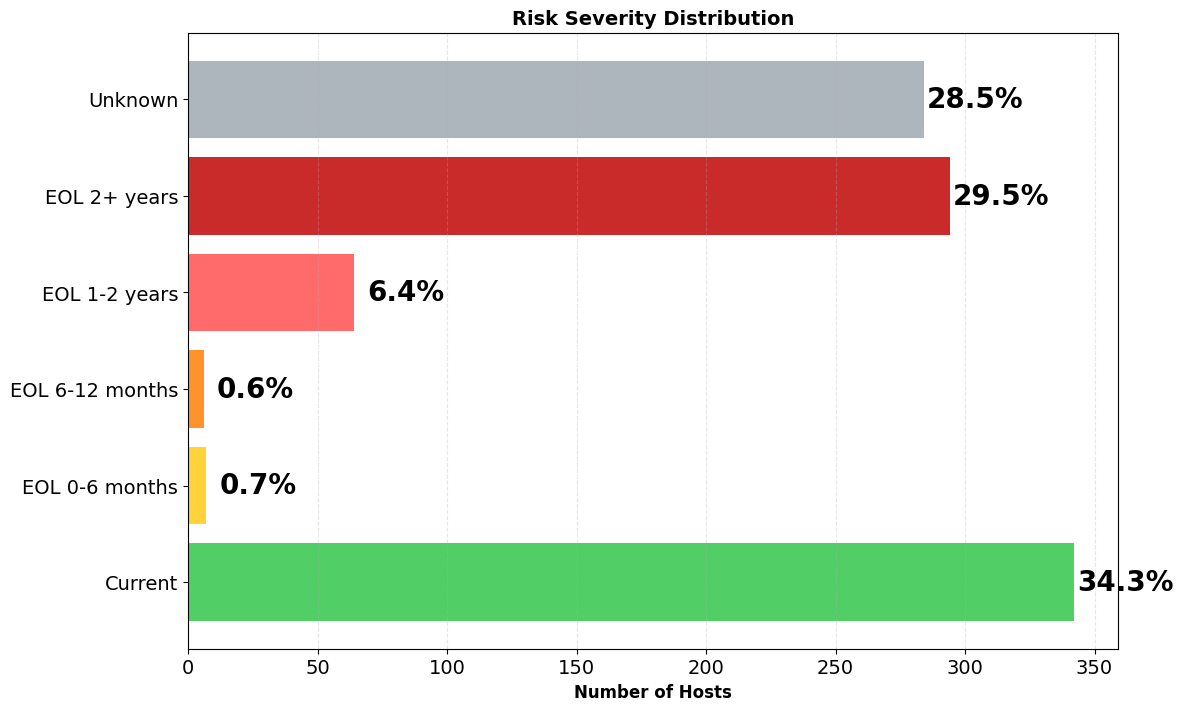

In [88]:
def create_risk_severity_dashboard(df):
    """Create risk severity dashboard with stacked bar chart"""

    # Count by risk category
    risk_counts = df['risk_category'].value_counts()

    # Define risk order and colors
    risk_order = [
        'Current',
        'EOL 0-6 months',
        'EOL 6-12 months',
        'EOL 1-2 years',
        'EOL 2+ years',
        'EOL (Date Unknown)',
        'Unknown'
    ]

    risk_colors = {
        'Current': '#51cf66',
        'EOL 0-6 months': '#ffd43b',
        'EOL 6-12 months': '#ff922b',
        'EOL 1-2 years': '#ff6b6b',
        'EOL 2+ years': '#c92a2a',
        'EOL (Date Unknown)': '#845ef7',
        'Unknown': '#adb5bd'
    }

    # Prepare data in correct order
    ordered_counts = []
    ordered_labels = []
    ordered_colors = []

    for category in risk_order:
        if category in risk_counts.index:
            ordered_counts.append(risk_counts[category])
            ordered_labels.append(category)
            ordered_colors.append(risk_colors[category])

    # Create horizontal stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 8))

    # Left plot: Horizontal bar chart
    bars = ax.barh(range(len(ordered_labels)), ordered_counts, color=ordered_colors)
    ax.set_yticks(range(len(ordered_labels)))
    ax.set_yticklabels(ordered_labels)
    ax.set_xlabel('Number of Hosts', fontsize=12, weight='bold')
    ax.set_title('Risk Severity Distribution', fontsize=14, weight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    total_hosts = len(df)

    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, ordered_counts)):
        # # Total label on the end of the bar
        # ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
        #         str(count), va='center', fontsize=20, weight='bold')

        # Percentage label in the center of the bar
        percentage = (count / total_hosts) * 100
        ax.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
                f'{percentage:.1f}%', va='center', ha='center',
                fontsize=20, weight='bold')

    plt.savefig('eol_severity_plot_transip.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

create_risk_severity_dashboard(df)

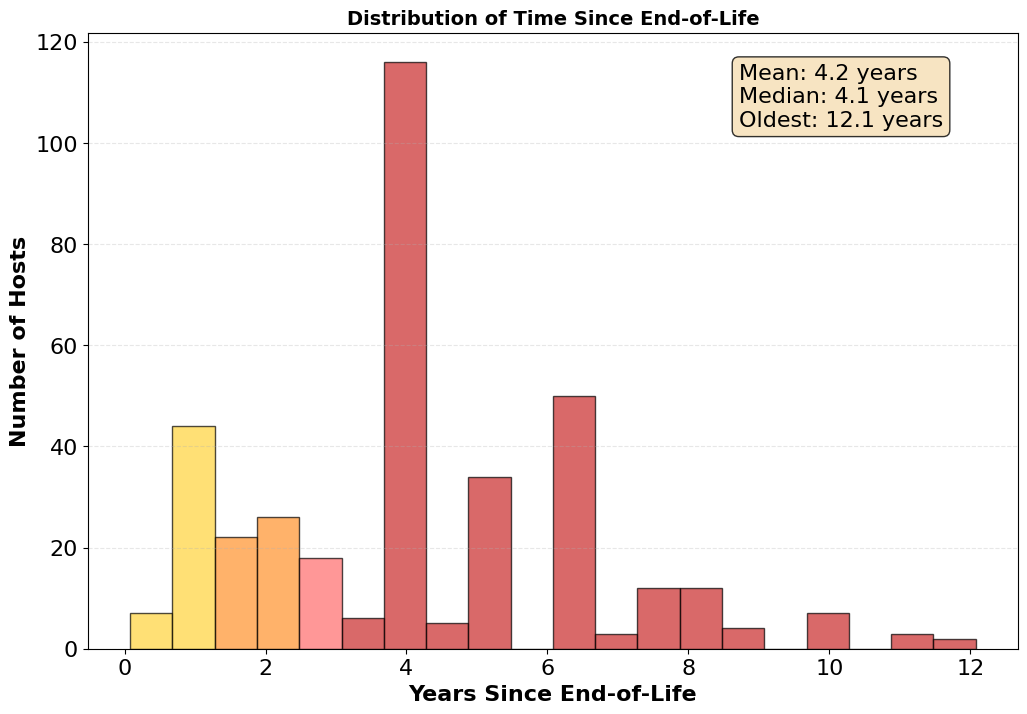

In [89]:
def create_age_distribution_histogram(df):
    """Create age distribution histogram for EOL software"""

    # Filter for EOL software with known dates
    eol_with_dates = df[(df['is_eol'] == True) & (df['days_since_eol'].notna())]

    if len(eol_with_dates) == 0:
        print("No EOL software with known dates found for age distribution.")
        return

    # Convert days to years for better readability
    years_since_eol = eol_with_dates['days_since_eol'] / 365.25

    # Create figure with subplots
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Top plot: Histogram of years since EOL
    n_bins = min(20, len(years_since_eol))
    n, bins, patches = ax1.hist(years_since_eol, bins=n_bins, edgecolor='black', alpha=0.7)

    # Color bars based on age (red for older)
    for i, patch in enumerate(patches):
        if bins[i] < 1:
            patch.set_facecolor('#ffd43b')  # Yellow for < 1 year
        elif bins[i] < 2:
            patch.set_facecolor('#ff922b')  # Orange for 1-2 years
        elif bins[i] < 3:
            patch.set_facecolor('#ff6b6b')  # Red for 2-3 years
        else:
            patch.set_facecolor('#c92a2a')  # Dark red for 3+ years

    ax1.set_xlabel('Years Since End-of-Life', fontsize=16, weight='bold')
    ax1.set_ylabel('Number of Hosts', fontsize=16, weight='bold')
    ax1.set_title('Distribution of Time Since End-of-Life', fontsize=14, weight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')

    # Add statistics text
    mean_age = years_since_eol.mean()
    median_age = years_since_eol.median()
    max_age = years_since_eol.max()

    stats_text = f'Mean: {mean_age:.1f} years\nMedian: {median_age:.1f} years\nOldest: {max_age:.1f} years'
    ax1.text(0.7, 0.95, stats_text, transform=ax1.transAxes, fontsize=16,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax1.tick_params(axis='y', labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)

    plt.savefig('eol_time_distribution_plot_transip.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

create_age_distribution_histogram(df)